<a href="https://colab.research.google.com/github/DMXMax/covid19/blob/master/coviddata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import io
import matplotlib.pyplot as plt


In [0]:
dfData = pd.read_csv("/content/CoronaVirusNumbersByState202003012.tsv",
                     sep='\t', thousands=',')
#dfData.loc[(dfData.Date == 20200309) & (dfData.State=='WA'),['Negative']]= 1100
dfData.fillna(0, inplace=True)
dfData.Negative = dfData.Negative.astype('int64')
dfData.Positive = dfData.Positive.astype('int64')
dfData.Pending = dfData.Pending.astype('int64')
dfData.Total = dfData.Total.astype('int64')
dfData.Death = dfData.Death.astype('int64')

In [0]:
dfData.dtypes

Date         int64
State       object
Positive     int64
Negative     int64
Pending      int64
Death        int64
Total        int64
dtype: object

In [0]:
res = dfData.loc[dfData.Date==20200310, ['Positive', 'Negative', 'Pending', 'Total']].sum()
print(res)
print(f"Current Infection Rate {res.Positive/res.Total*100:2f}%")

Positive     778
Negative    3807
Pending      469
Total       4889
dtype: int64
Current Infection Rate 15.913275%


In [0]:
dfData.dtypes



Date         int64
State       object
Positive     int64
Negative     int64
Pending      int64
Death        int64
Total        int64
dtype: object

In [0]:
dfData.index

RangeIndex(start=0, stop=380, step=1)

In [0]:
dfData.describe()

,Date,Positive,Negative,Pending,Death,Total
count,3.800000e+02,380.000000,380.000000,380.000000,380.000000,380.000000
mean,2.020031e+07,13.144737,75.631579,9.802632,0.165789,98.307895
std,2.290551e+00,37.148175,232.563178,26.634544,1.944178,267.720698
min,2.020030e+07,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.020031e+07,0.000000,0.000000,0.000000,0.000000,7.000000
50%,2.020031e+07,2.000000,18.000000,0.000000,0.000000,28.500000
75%,2.020031e+07,8.000000,53.000000,7.000000,0.000000,72.500000
max,2.020031e+07,337.000000,3037.000000,236.000000,29.000000,3403.000000


In [0]:
dfData.loc[:, ['State', 'Positive']].sort_values(by='Positive')

,State,Positive
0,AK,0
240,ID,0
241,AK,0
242,IA,0
243,OH,0
...,...,...
4,CA,198
34,NY,216
85,NY,216
98,WA,267


In [0]:
dfData[(dfData.Positive >0) & (dfData.Date==20200309)].sort_values(by='Positive').Date.count()

37

In [0]:
dfPositive= dfData[dfData.Positive>0]

In [0]:
dfPositive[dfPositive.State=='CA']

,Date,State,Positive,Negative,Pending,Death,Total
4,20200312,CA,198,916,0,4,1118
55,20200311,CA,157,916,0,0,1073
106,20200310,CA,133,690,0,0,823
157,20200309,CA,114,690,0,0,804
206,20200308,CA,88,462,0,0,550
257,20200307,CA,69,462,0,0,531
307,20200306,CA,60,462,0,0,522
343,20200305,CA,53,462,0,0,515
367,20200304,CA,53,462,0,0,515


In [0]:
df2 = dfPositive.State.unique()

In [0]:
df2

array(['AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI', 'IA',
       'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO',
       'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT',
       'WA', 'WI', 'WY'], dtype=object)

In [0]:
df1 = dfPositive[dfPositive.Date == 20200308].State
df2 = dfPositive[dfPositive.Date == 20200309].State

In [0]:
print(df1.count())
print(df2.count())

34
37


In [0]:
dfData.Pending

0      14
1       0
2      20
3      24
4       0
       ..
375    18
376     0
377     0
378     0
379     6
Name: Pending, Length: 380, dtype: int64

In [0]:
dfByDate = dfData.groupby(by='Date').sum()

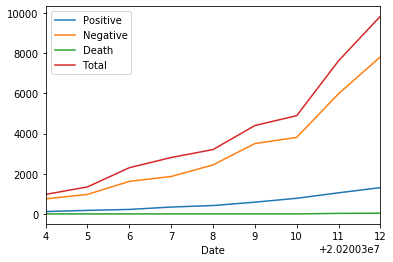

In [0]:
dfByDate.loc[:, ['Positive', 'Negative','Death','Total']].plot.line()

In [0]:
dfByDate

,Positive,Negative,Pending,Death,Total
Date,,,,,
20200304,118,748,103,0,969
20200305,176,971,197,0,1344
20200306,223,1617,458,0,2298
20200307,341,1863,602,0,2806
20200308,417,2437,347,0,3201
20200309,584,3500,313,0,4397
20200310,778,3807,469,0,4889
20200311,1050,5978,563,27,7617
20200312,1308,7819,673,36,9836


In [0]:
dfWHO = pd.read_csv("/content/who_data.tsv",
                     sep='\t', index_col='Date')

In [0]:
dfWHO.rename(columns={'Deaths': 'who_Deaths'}, inplace=True)

In [0]:
dfWHO.tail()



,Confirmed,who_Deaths
Date,,
20200308,213,11
20200309,213,11
20200310,472,19
20200311,696,25
20200312,987,29


In [0]:
dfWHO


,Confirmed,who_Deaths
Date,,
20200304,108,6
20200305,129,9
20200306,148,10
20200307,213,11
20200308,213,11
20200309,213,11
20200310,472,19
20200311,696,25
20200312,987,29


In [0]:
dfResults = dfByDate.join(dfWHO, how='left', rsuffix='_who' )

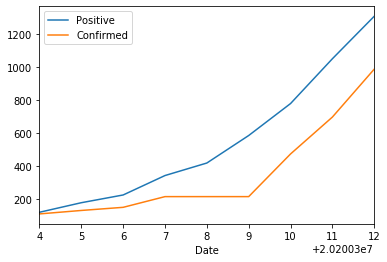

In [0]:
dfResults.loc[:, ['Positive', 'Confirmed']].plot.line()

In [0]:
dfData[dfData.State=='CA'].sort_values(by='Date')

,Date,State,Positive,Negative,Pending,Death,Total
367,20200304,CA,53,462,0,0,515
343,20200305,CA,53,462,0,0,515
307,20200306,CA,60,462,0,0,522
257,20200307,CA,69,462,0,0,531
206,20200308,CA,88,462,0,0,550
157,20200309,CA,114,690,0,0,804
106,20200310,CA,133,690,0,0,823
55,20200311,CA,157,916,0,0,1073
4,20200312,CA,198,916,0,4,1118


In [0]:
dfResults

,Positive,Negative,Pending,Death,Total,Confirmed,who_Deaths
Date,,,,,,,
20200304,118,748,103,0,969,108,6
20200305,176,971,197,0,1344,129,9
20200306,223,1617,458,0,2298,148,10
20200307,341,1863,602,0,2806,213,11
20200308,417,2437,347,0,3201,213,11
20200309,584,3500,313,0,4397,213,11
20200310,778,3807,469,0,4889,472,19
20200311,1050,5978,563,27,7617,696,25
20200312,1308,7819,673,36,9836,987,29


In [0]:
157-198


-41

In [0]:
columns = ['State','Country','LastUpdate','Confirmed','Deaths','Recovered', 'Lat','Long']
dfTest = pd.read_csv("/content/03-12-2020.csv",header=0, names=columns)

In [0]:
dfTest.dtypes

State          object
Country        object
LastUpdate     object
Confirmed       int64
Deaths          int64
Recovered       int64
Lat           float64
Long          float64
dtype: object

In [0]:
dfUSA = dfTest[dfTest.Country=='US']

In [0]:
dfUSA

,State,Country,LastUpdate,Confirmed,Deaths,Recovered,Lat,Long
26,Washington,US,2020-03-12T23:44:33,442,31,1,47.4009,-121.4905
29,New York,US,2020-03-12T21:39:10,328,0,0,42.1657,-74.9481
37,California,US,2020-03-12T23:44:33,221,4,6,36.1162,-119.6816
50,Massachusetts,US,2020-03-12T21:39:09,108,0,1,42.2302,-71.5301
76,Diamond Princess,US,2020-03-10T02:33:04,46,0,0,35.4437,139.6380
78,Colorado,US,2020-03-12T21:39:10,45,0,0,39.0598,-105.3111
82,Florida,US,2020-03-12T21:39:10,35,2,0,27.7663,-81.6868
84,Illinois,US,2020-03-12T23:44:33,32,0,2,40.3495,-88.9861
85,Georgia,US,2020-03-12T21:39:10,31,1,0,33.0406,-83.6431
86,New Jersey,US,2020-03-12T21:39:10,29,1,0,40.2989,-74.5210


In [0]:
dfUSA.loc[:,['Confirmed', 'Deaths']].sum()

Confirmed    1663
Deaths         40
dtype: int64

In [0]:
dfUSA[dfUSA.Confirmed>0]

,State,Country,LastUpdate,Confirmed,Deaths,Recovered,Lat,Long
26,Washington,US,2020-03-12T23:44:33,442,31,1,47.4009,-121.4905
29,New York,US,2020-03-12T21:39:10,328,0,0,42.1657,-74.9481
37,California,US,2020-03-12T23:44:33,221,4,6,36.1162,-119.6816
50,Massachusetts,US,2020-03-12T21:39:09,108,0,1,42.2302,-71.5301
76,Diamond Princess,US,2020-03-10T02:33:04,46,0,0,35.4437,139.6380
78,Colorado,US,2020-03-12T21:39:10,45,0,0,39.0598,-105.3111
82,Florida,US,2020-03-12T21:39:10,35,2,0,27.7663,-81.6868
84,Illinois,US,2020-03-12T23:44:33,32,0,2,40.3495,-88.9861
85,Georgia,US,2020-03-12T21:39:10,31,1,0,33.0406,-83.6431
86,New Jersey,US,2020-03-12T21:39:10,29,1,0,40.2989,-74.5210


In [0]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/03-12-2020.csv --quiet --output-document ./sample_data/20200312.csv

In [0]:
dfJHUData = pd.read_csv('./sample_data/20200312.csv', header=0,
                        names=['State', 'Country', 'LastUpdate',
                               'Confirmed', 'Dead', 'Recovered', 'Lat','Lon'])

In [0]:
dfJHUData[dfJHUData.Country=='US'][['Confirmed', 'Dead']].sum()

Confirmed    1663
Dead           40
dtype: int64

In [0]:
dfJHUData = pd.read_csv('./sample_data/20200312.csv')

In [0]:
dfJHUData.columns

Index(['Province/State', 'Country/Region', 'Last Update', 'Confirmed',
       'Deaths', 'Recovered'],
      dtype='object')

In [0]:
dfJHUData.head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,Anhui,Mainland China,1/22/2020 17:00,1.0,NaN,NaN
1,Beijing,Mainland China,1/22/2020 17:00,14.0,NaN,NaN
2,Chongqing,Mainland China,1/22/2020 17:00,6.0,NaN,NaN
3,Fujian,Mainland China,1/22/2020 17:00,1.0,NaN,NaN
4,Gansu,Mainland China,1/22/2020 17:00,NaN,NaN,NaN
